In [1]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import cv2
# import transform
from torchvision import transforms
import math
import numpy as np
from tqdm import tqdm
from PIL import Image
from IPython.display import HTML
from base64 import b64encode
import subprocess
import os

In [3]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_CLASSES = 4
CLASSES = [
    '__background__',
    'basketball', 'hoop', 'person',
]
model = fasterrcnn_resnet50_fpn(
        weights='DEFAULT'
    )
in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, NUM_CLASSES) 
checkpoint = torch.load("fastercnn-pytorch-training-pipeline/outputs/training/basketball_detect_training/best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.to(DEVICE).eval();

In [3]:
def get_prediction(model, imgs):
    # convert list of images to a batch of tensor
    imgs = torch.stack(imgs).to(DEVICE)
    
    with torch.no_grad():
        predictions = model(imgs)
    return predictions

def convert_detections(
    outputs, 
    detection_threshold, 
    classes,
    args
):
    """
    Return the bounding boxes, scores, and classes.
    """
    boxes = outputs['boxes'].data.cpu().numpy()
    scores = outputs['scores'].data.cpu().numpy()


    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    draw_boxes = boxes.copy()
    # Get all the predicited class names.
    pred_classes = [classes[i] for i in outputs['labels'].cpu().numpy()]

    return draw_boxes, pred_classes, scores


In [77]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

video_path = "clips/20230705_Game6.mp4"
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
batch_size = 64
num_batches = math.ceil(total_frames / batch_size)
results = []

frames = []
for i in tqdm(range(num_batches)):
    frame_count = 0
    #frames = []
    for i in range(batch_size):
        ret, img = cap.read()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if ret:
            frames.append(transform(img))
        else:
            break
    break

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:03<?, ?it/s]


In [40]:
predictions = get_prediction(model, frames)

In [58]:


# Assuming DEVICE is defined (e.g., torch.device("cuda" if torch.cuda.is_available() else "cpu"))
# Assuming 'model' is already defined and loaded
CLASSES = [
    '__background__',  # Typically, 0 is for background
    'basketball', 'hoop', 'person',
]


def draw_boxes(img, boxes, labels, scores, width, height, threshold=0.5):
    
    # Draw bounding box with label and probability
    for box, label, score in zip(boxes, labels, scores):
        p1 = (int(box[0]/img.shape[1]*width), int(box[1]/img.shape[0]*height))
        p2 = (int(box[2]/img.shape[1]*width), int(box[3]/img.shape[0]*height))
        if score > threshold:
            x1, y1, x2, y2 = p1[0], p1[1], p2[0], p2[1]
            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            label_text = f'{CLASSES[label]}: {score:.2f}'
            cv2.putText(img, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return img

def get_prediction(model, imgs, transform = None):
    # Convert list of images to a batch of tensor
    if transform:
        imgs = [transform(img) for img in imgs]
    imgs = torch.stack(imgs).to(DEVICE)
    with torch.no_grad():
        predictions = model(imgs)
    return predictions

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((640, 640)),
    transforms.ToTensor()
])

video_path = "clips/20230705_Game6.mp4"
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))
batch_size = 64
num_batches = math.ceil(total_frames / batch_size)
results = []
video_name = video_path.split("/")[-1]
output_path = "inferenced_" + video_name
codec = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, codec, fps, (frame_width,frame_height))

for i in tqdm(range(num_batches)):
    frames = []
    for _ in range(batch_size):
        ret, img = cap.read()
        if ret:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            frame = 
            frames.append(img)
        else:
            print("No more frames to read or error reading frame")  # Debug print
            break
    
    if frames:
        predictions = get_prediction(model, frames, transform)

        # Process each frame in the batch
        for img, pred in zip(frames, predictions):
            img = np.array(img)

            boxes = pred['boxes'].to('cpu').numpy()
            labels = pred['labels'].to('cpu').numpy()
            scores = pred['scores'].to('cpu').numpy()
            draw_boxes(img, boxes, labels, scores, frame_width, frame_height)
            img = cv2.resize(img, (frame_width, frame_height))
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

            out.write(img)
    else:
        break

out.release()
cap.release()


 50%|█████     | 3/6 [00:08<00:08,  2.78s/it]

No more frames to read or error reading frame


 67%|██████▋   | 4/6 [00:10<00:05,  2.61s/it]

No more frames to read or error reading frame


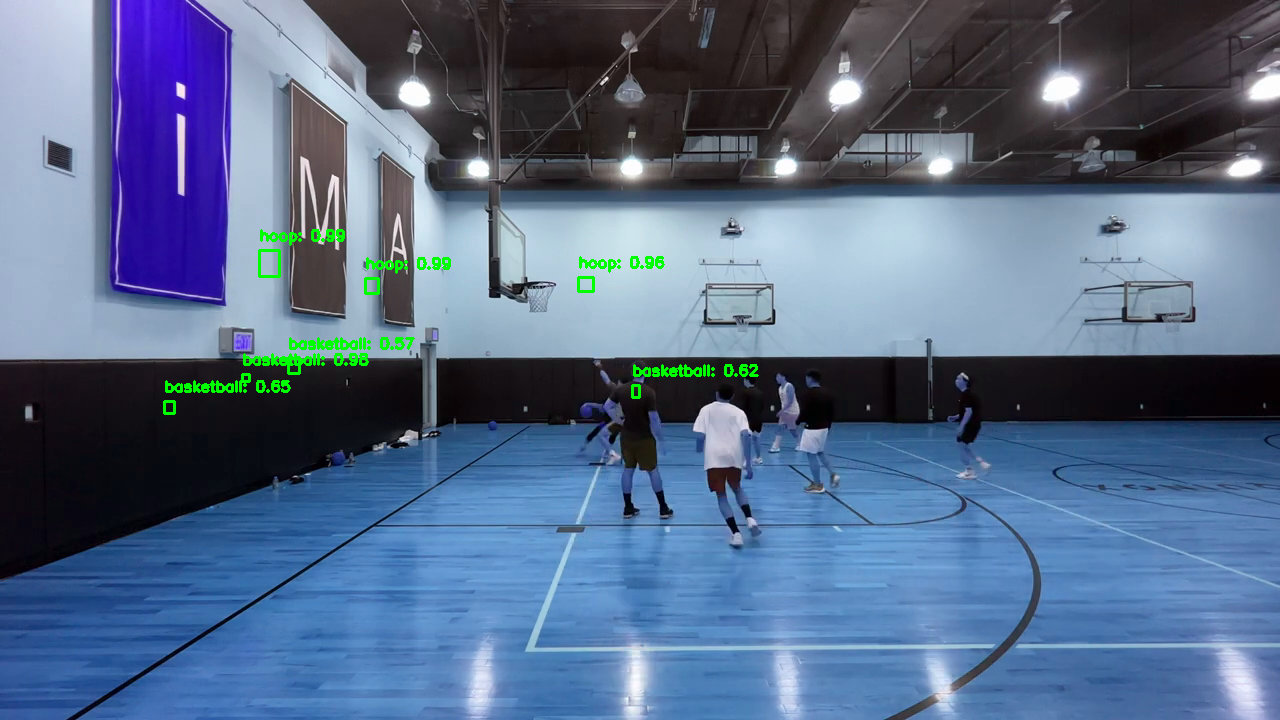

In [59]:
Image.fromarray(img_with_boxes)

In [55]:
def inference_annotations(
    draw_boxes, 
    pred_classes, 
    scores, 
    classes,
    colors, 
    orig_image, 
    image, 
    track = False,
    no_labels = True,
):
    height, width, _ = orig_image.shape
    lw = max(round(sum(orig_image.shape) / 2 * 0.003), 2)  # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    
    # Draw the bounding boxes and write the class name on top of it.
    for j, box in enumerate(draw_boxes):
        p1 = (int(box[0]/image.shape[1]*width), int(box[1]/image.shape[0]*height))
        p2 = (int(box[2]/image.shape[1]*width), int(box[3]/image.shape[0]*height))
        class_name = pred_classes[j]
        if track:
            color = colors[classes.index(' '.join(class_name.split(' ')[1:]))]
        else:
            color = colors[classes.index(class_name)]
        cv2.rectangle(
            orig_image,
            p1, p2,
            color=color, 
            thickness=lw,
            lineType=cv2.LINE_AA
        )
        if no_labels:
            # For filled rectangle.
            final_label = class_name + ' ' + str(round(scores[j], 2))
            w, h = cv2.getTextSize(
                final_label, 
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw / 3, 
                thickness=tf
            )[0]  # text width, height
            w = int(w - (0.20 * w))
            outside = p1[1] - h >= 3
            p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
            cv2.rectangle(
                orig_image, 
                p1, 
                p2, 
                color=color, 
                thickness=-1, 
                lineType=cv2.LINE_AA
            )  
            cv2.putText(
                orig_image, 
                final_label, 
                (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
                cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=lw / 3.8, 
                color=(255, 255, 255), 
                thickness=tf, 
                lineType=cv2.LINE_AA
            )
    return orig_image

In [56]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    #transforms.Resize((640, 640)),
    transforms.ToTensor()
])
COLORS = np.random.uniform(0, 255, size=(len(CLASSES), 3))
video_path = "clips/20230705_Game6.mp4"
cap = cv2.VideoCapture(video_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))
fps = int(cap.get(cv2.CAP_PROP_FPS))
batch_size = 32
num_batches = math.ceil(total_frames / batch_size)
results = []
video_name = video_path.split("/")[-1]
output_path = "inferenced_" + video_name
codec = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, codec, fps, (frame_width,frame_height))

while cap.isOpened():
    ret, frame = cap.read()
    if ret:
        orig_frame = frame.copy()
        frame = cv2.resize(frame, (640, 640))
        image = frame.copy()
        image = transform(image)
        outputs = get_prediction(model, [image])
        outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
        if outputs[0]['boxes'].shape[0] != 0:
            boxes = outputs[0]['boxes'].data.cpu().numpy()
            scores = outputs[0]['scores'].data.cpu().numpy()
            pred_classes = outputs[0]['labels'].data.cpu().numpy()
            pred_classes = [CLASSES[i] for i in pred_classes]
            
            frame = inference_annotations(
                boxes, 
                pred_classes, 
                scores, 
                CLASSES,
                COLORS, 
                orig_frame, 
                frame
            )
        else:
            frame = orig_frame
        out.write(frame)
        
    else:
        break
out.release()
cap.release()
            
        

TypeError: get_prediction() missing 1 required positional argument: 'transform'

In [34]:
cap = cv2.VideoCapture(output_path)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
total_frames

241

In [36]:
def display_compressed_video(input_path):
    output_path = "compressed_" + input_path
    os.remove(output_path) if os.path.exists(output_path) else None
    try:
        # Use subprocess to safely call FFmpeg
        subprocess.run(['ffmpeg', '-i', input_path, '-vcodec', 'libx264', output_path], check=True)

        # Read and encode the compressed video
        with open(output_path, 'rb') as file:
            mp4 = file.read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

        # Display video in HTML
        display_html = f"""
        <video width=800 controls>
            <source src="{data_url}" type="video/mp4">
        </video>
        """
        return HTML(display_html)
    except subprocess.CalledProcessError as e:
        print(f"An error occurred: {e}")

In [54]:
display_compressed_video('inferenced_20230705_Game6.mp4')

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab